01DataPreprocessing

In this notebook we impute missing values 

In [2]:
import pandas as pd
import numpy as np
import random
import pickle
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 

Imputing missing values

In [2]:
def impute_missing_vals(df, attributes):
    """
    fill missing values by the closest values first
    ffill to fill missing values in the tail
    bfill to fill missing values in the head
    """
    df_clean = df.copy()
    for att in attributes:
        if df_clean[att].isnull().sum() == len(df_clean):
            df_clean[att] = df_clean[att].fillna(0)
        elif df_clean[att].isnull().sum() == len(df_clean) - 1:
            df_clean[att] = df_clean[att].ffill().bfill()
        else:
            df_clean[att] = df_clean[att].interpolate(method='nearest', limit_direction='both')
            df_clean[att] = df_clean[att].ffill().bfill()
    
    return df_clean

def create_imputed_patient_files(in_dir, out_dir, drop_list):
    for patient in sorted(os.listdir(in_dir)):
    
        df_raw   = pd.read_csv(in_dir + '\\' + patient, sep = "|")
        df_clean = impute_missing_vals(df_raw, df_raw.columns[:-1])
        df_clean = df_clean.drop(drop_list, axis=1)

        df_clean.to_csv(out_dir + "\\" + patient, sep='|')

In [4]:
'''
Load raw data, impute missing values, drop features and save imputed patient data.
'''

RAW_DATA_DIR     = r"D:\\DesktopMT\\FRI\\semester_1\\ML\\Proj\\Sepsis-Analysis\\raw_data"
IMPUTED_DATA_DIR = r"D:\\DesktopMT\\FRI\\semester_1\\ML\\Proj\\Sepsis-Analysis\\imput_data"
DROP_FEATURES    = ['Unit1', 'Unit2', 'EtCO2']

'''
create_imputed_patient_files(in_dir = RAW_DATA_DIR, out_dir = IMPUTED_DATA_DIR, drop_list = DROP_FEATURES)
'''

'\ncreate_imputed_patient_files(in_dir = RAW_DATA_DIR, out_dir = IMPUTED_DATA_DIR, drop_list = DROP_FEATURES)\n'

In [6]:
'''
Split imputed data into train, test, validation sub-sets and store
them in individual folders.
'''
TEST_DATA_DIR    = r"D:\\DesktopMT\\FRI\\semester_1\\ML\\Proj\\Sepsis-Analysis\\test_data"
TRAIN_DATA_DIR   = r"D:\\DesktopMT\\FRI\\semester_1\\ML\\Proj\\Sepsis-Analysis\\train_data"
VALID_DATA_DIR   = r"D:\\DesktopMT\\FRI\\semester_1\\ML\\Proj\\Sepsis-Analysis\\valid_data"
IMPUTED_DATA_DIR = r"D:\\DesktopMT\\FRI\\semester_1\\ML\\Proj\\Sepsis-Analysis\\imput_data"

TRAIN_PERC = 0.70
TEST_PERC  = 0.15
VALID_PERC = 0.15

def train_test_validate_split(test_perc, train_perc, valid_perc, data_dir, test_dir, train_dir, valid_dir):
    
    patients       = (os.listdir(data_dir))

    plt.plot([int(pat_str[1 : 7]) for pat_str in patients])
    plt.show()

    patients_num   = len(patients)
    train_set_size = round(train_perc * patients_num) + 1
    valid_set_size = round(valid_perc *   patients_num)
    test_set_size  = round(test_perc *   patients_num)

    train_patients = random.sample(patients, train_set_size)
    valid_patients = random.sample(set(patients) - set(train_patients), valid_set_size)
    test_patients  = set(patients) - set(train_patients) - set(valid_patients)


    for patient in train_patients:
        df = pd.read_csv(data_dir + '\\' + patient, sep = "|")
        df.to_csv(train_dir  + '\\' + patient, sep='|', index = False)

    for patient in valid_patients:
        df = pd.read_csv(data_dir + '\\' + patient, sep = "|")
        df.to_csv(valid_dir  + '\\' + patient, sep='|', index = False)

    for patient in test_patients:
        df = pd.read_csv(data_dir + '\\' + patient, sep = "|")
        df.to_csv(test_dir  + '\\' + patient, sep='|', index = False)

'''
train_test_validate_split(test_perc = TEST_PERC, train_perc = TRAIN_PERC, valid_perc = VALID_PERC, data_dir = IMPUTED_DATA_DIR, test_dir = TEST_DATA_DIR, train_dir = TRAIN_DATA_DIR, valid_dir = VALID_DATA_DIR)
'''

'\ntrain_test_validate_split(test_perc = TEST_PERC, train_perc = TRAIN_PERC, valid_perc = VALID_PERC, data_dir = IMPUTED_DATA_DIR, test_dir = TEST_DATA_DIR, train_dir = TRAIN_DATA_DIR, valid_dir = VALID_DATA_DIR)\n'

In [7]:
'''
Concate patients in each category.
'''
def concatenate_patients(patients_dir):
    patients = []

    for patient in os.listdir(patients_dir):
        df = pd.read_csv(patients_dir + '\\' + patient, sep = "|")
        patients.append(df)

    return pd.concat(patients)

train_df = concatenate_patients(patients_dir = TRAIN_DATA_DIR)
valid_df = concatenate_patients(patients_dir = VALID_DATA_DIR)
test_df  = concatenate_patients(patients_dir = TEST_DATA_DIR)

with open('train_valid_test_data.pickle', 'wb') as f:
    pickle.dump([train_df, valid_df, test_df], f)

"\nSave dataframes.\n\nwith open('train_valid_test_data.pickle', 'wb') as f:\n    pickle.dump([train_df, valid_df, test_df], f)\n"

In [4]:
with open('train_valid_test_data.pickle', 'rb') as f:
    [train_df, valid_df, test_df] = pickle.load(f)

train_df.drop(train_df.columns[train_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
valid_df.drop(valid_df.columns[valid_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
test_df.drop(test_df.columns[test_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

''' 
Merge test and validation data.
'''
test_df = pd.concat([test_df,valid_df])

def split_features_and_labels(df):
    cols = df.columns
    return np.array(df[cols[:-1]].values), df[cols[-1]].values

X_train, y_train = split_features_and_labels(train_df)
X_valid, y_valid = split_features_and_labels(valid_df)
X_test, y_test   = split_features_and_labels(test_df)

array([[<AxesSubplot:title={'center':'HR'}>,
        <AxesSubplot:title={'center':'O2Sat'}>,
        <AxesSubplot:title={'center':'Temp'}>,
        <AxesSubplot:title={'center':'SBP'}>,
        <AxesSubplot:title={'center':'MAP'}>,
        <AxesSubplot:title={'center':'DBP'}>],
       [<AxesSubplot:title={'center':'Resp'}>,
        <AxesSubplot:title={'center':'BaseExcess'}>,
        <AxesSubplot:title={'center':'HCO3'}>,
        <AxesSubplot:title={'center':'FiO2'}>,
        <AxesSubplot:title={'center':'pH'}>,
        <AxesSubplot:title={'center':'PaCO2'}>],
       [<AxesSubplot:title={'center':'SaO2'}>,
        <AxesSubplot:title={'center':'AST'}>,
        <AxesSubplot:title={'center':'BUN'}>,
        <AxesSubplot:title={'center':'Alkalinephos'}>,
        <AxesSubplot:title={'center':'Calcium'}>,
        <AxesSubplot:title={'center':'Chloride'}>],
       [<AxesSubplot:title={'center':'Creatinine'}>,
        <AxesSubplot:title={'center':'Bilirubin_direct'}>,
        <AxesSubplot:titl

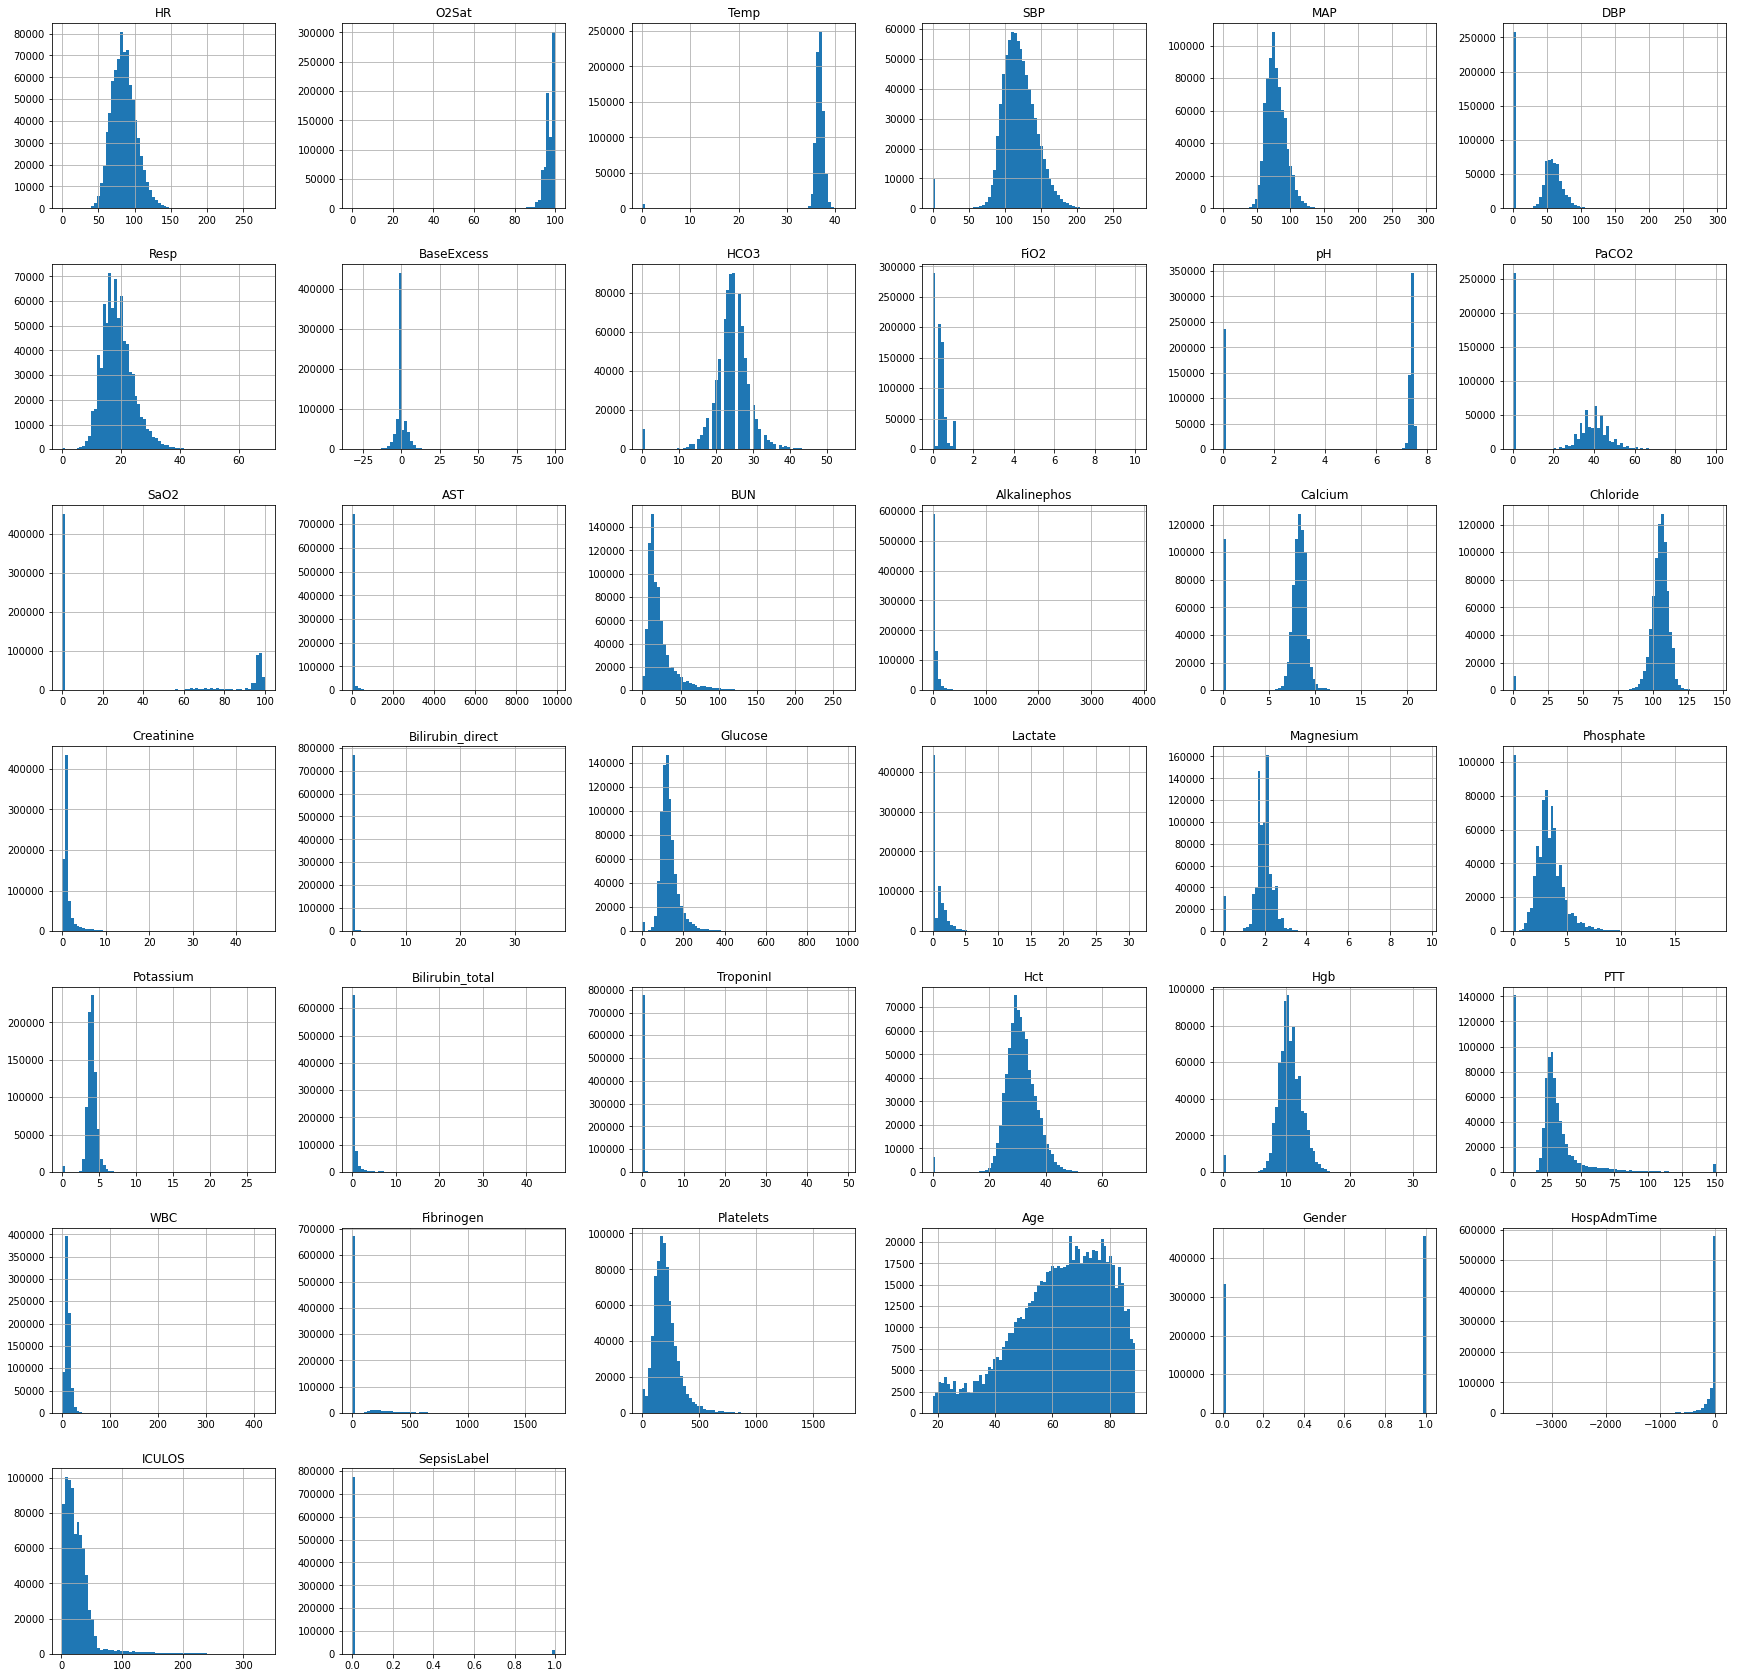

In [7]:
''' 
Data distrubution after imputing.
Distribution of atributes which prev. had many missing values has changed.
'''

df = pd.concat([train_df, test_df])
df.hist(figsize = (30,30), bins = 70)